In [21]:
import re

import sulfur
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

# Fitting $\mu_S$

Some previous attempts at fitting the system with polynomials have proven problematic. This is likely due to over-fitting, particularly at pressures where one polynomial is sufficient to describe the behaviour. We therefore try a more rational approach in which many parameters are assumed to be pressure invariant.

For a single species, we would expect a polynomial in temperature with a pressure correction to provide a sufficient model:

\begin{equation}
\mu_{S_i}(T,P) = f(T) + f(T,P) \approx a + bT + cT^2 + dT^3 + RT \log \frac{P}{P_{ref}}
\end{equation}

We can check this against some model data:

In [22]:
import ase.db
import ase.thermochemistry
from scipy import constants
from sulfur import cm_to_hz, reference_energy
#from sulfur.core import get_potentials, unpack_data, reference_energy, solve_composition
db_file = sulfur.__path__[0] + '/../data/sulfur_pbe0_96.json'
ref_energy = reference_energy(db_file)
c = ase.db.connect(db_file)
s8_dict = c.get_dict('S8')
s8_atoms = c.get_atoms('S8')
s8_vib_energies = cm_to_hz(np.array(s8_dict.data.frequencies)) * constants.physical_constants['Planck constant in eV s'][0]
s8_thermo = ase.thermochemistry.IdealGasThermo(s8_vib_energies, s8_dict.data.geometry, 
                                               electronicenergy=s8_atoms.get_total_energy() - ref_energy*8, 
                                               atoms=s8_atoms, symmetrynumber=s8_dict.data.symmetry, spin=0)

Fitting to 1 bar standard pressure:

In [23]:
T = np.linspace(100,1500,100)
mu_s8_eV_1bar = [s8_thermo.get_gibbs_energy(t,1E5, verbose=False) for t in T]
s8_polyfits = [scipy.polyfit(T,mu_s8_eV_1bar,i) for i in range(2,5)]

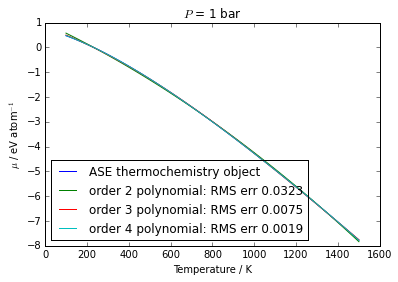

In [24]:
def rms_diff(iter1, iter2):
    "Calculate the root mean square difference between two iterables"
    iter1, iter2 = np.array(iter1), np.array(iter2)
    diff = iter1 - iter2
    return np.sqrt(np.mean(np.square(diff)))

plt.plot(T,mu_s8_eV_1bar, label="ASE thermochemistry object")
i=2
for fit in s8_polyfits:
    mu = scipy.polyval(fit, T)
    plt.plot(T, mu, label='order {0} polynomial: RMS err {1:5.4f}'.format(i, rms_diff(mu_s8_eV_1bar, mu)))
    i += 1
plt.legend(loc='best')
plt.xlabel('Temperature / K'); plt.ylabel('$\mu$ / eV atom$^{-1}$'); plt.title('$P$ = 1 bar')

We see that fitting is quite adequate even with an order-2 polynomial. Adding the pressure correction should be harmless as the same ideal gas law is used internally by the ASE thermochemistry object.

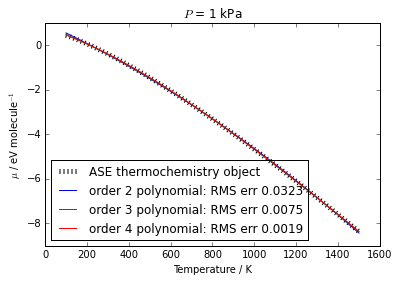

In [25]:
k = scipy.constants.physical_constants['Boltzmann constant in eV/K'][0]
mu_s8_eV_1kPa = [s8_thermo.get_gibbs_energy(t,1E3, verbose=False) for t in T]
plt.plot(T,mu_s8_eV_1kPa, 'k:', linewidth=5, label="ASE thermochemistry object")
i=2
for fit in s8_polyfits:
    mu = scipy.polyval(fit, T) + k*T*np.log(1E3/1E5)
    plt.plot(T, mu, label='order {0} polynomial: RMS err {1:5.4f}'.format(i, rms_diff(mu_s8_eV_1kPa, mu)))
    i += 1
plt.legend(loc='best')
plt.xlabel('Temperature / K'); plt.ylabel('$\mu$ / eV molecule$^{-1}$'); plt.title('$P$ = 1 kPa')

Reassuringly, the fitting error is completely unaffected. The next step is to create an equivalent fit for the S2 species.

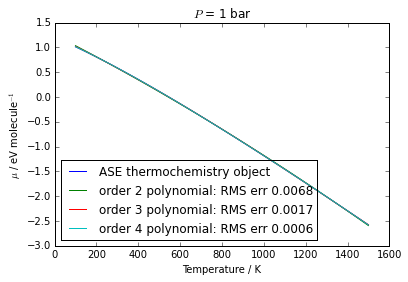

In [26]:
s2_dict = c.get_dict('S2')
s2_atoms = c.get_atoms('S2')
s2_vib_energies = cm_to_hz(np.array(s2_dict.data.frequencies)) * constants.physical_constants['Planck constant in eV s'][0]
s2_thermo = ase.thermochemistry.IdealGasThermo(s2_vib_energies, s2_dict.data.geometry, 
                                               electronicenergy=s2_atoms.get_total_energy() - ref_energy*2, 
                                               atoms=s2_atoms, symmetrynumber=s2_dict.data.symmetry, spin=0)
mu_s2_eV_1bar = [s2_thermo.get_gibbs_energy(t,1E5, verbose=False) for t in T]
s2_polyfits = [scipy.polyfit(T,mu_s2_eV_1bar,i) for i in range(2,5)]

plt.plot(T,mu_s2_eV_1bar, label="ASE thermochemistry object")
i=2
for fit in s2_polyfits:
    mu = scipy.polyval(fit, T)
    plt.plot(T, mu, label='order {0} polynomial: RMS err {1:5.4f}'.format(i, rms_diff(mu_s2_eV_1bar, mu)))
    i += 1
plt.legend(loc='best')
plt.xlabel('Temperature / K'); plt.ylabel('$\mu$ / eV molecule$^{-1}$'); plt.title('$P$ = 1 bar')

Dividing through by the number of atoms these relations should give a good start for fitting the solution for the mixture.

In [27]:
eqm_file =  sulfur.__path__[0] + '/../data/precise/mu_pbe0_scaled.csv'
try:
    eqm_table = np.genfromtxt(eqm_file, skip_header=1, delimiter=',')
except IOError:
    raise Exception("Need data for gas mixture. Try running 'plots.py' from the 'scripts' folder of the sulfur-model code.")

T_table = eqm_table[:,0]
with open(eqm_file,'r') as f:
    file_header = f.readline() # Read header in format # T/unit,mu (X Pa) / unit, mu (X Pa) / unit...

In [28]:
eV2jmol = constants.physical_constants['electron volt-joule relationship'][0]*constants.N_A

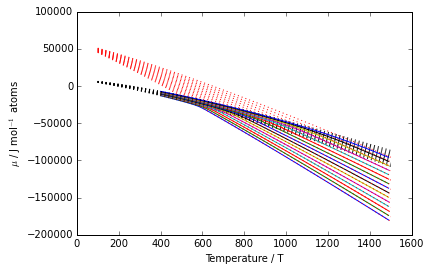

In [29]:
P_table = [np.double(p) for p in re.findall('(?<=mu \()[\d.]+(?= [A-z]*\))', file_header)]

P_units = re.findall('[A-z]+(?=\))', file_header)
for unit in P_units:
    if unit != 'Pa':
        raise Exception("Sorry, only Pa supported for now")
        
for i, p in enumerate(P_table):
    plt.plot(T_table, eqm_table[:,i+1])
    plt.plot(T, (scipy.polyval(s2_polyfits[-1],T) + k*T*np.log(p/1.0E5)) * eV2jmol/2, 'r:')
    plt.plot(T, (scipy.polyval(s8_polyfits[-1],T) + k*T*np.log(p/1.0E5)) * eV2jmol/8, 'k:')
    
plt.xlabel('Temperature / T'); plt.ylabel('$\mu$ / J mol$^{-1}$ atoms')

Otherwise, this is quite encouraging. It appears that a decent parameterisation may be formed by "switching" between these two well-defined potentials. A natural starting point for this switch-over is the point at which the free energies are equal on an atom basis. A little analysis reduces this to a polynomial problem in T at a given P.

\begin{align}
  \frac{\mu_{S_8} (T,P)}{8} &= \frac{\mu_{S_2} (T,P)}{2} \\
  \frac{\sum\limits^N_{i=0} x_{{S_8},i} T^i + k T \ln \frac{P}{P_{\mathrm{ref}}}}{8} &=
    \frac{\sum\limits^N_{i=0} x_{{S_2},i} T^i + k T \ln \frac{P}{P_{\mathrm{ref}}}}{2} \\
  \sum\limits^N_{i=0} x_{{S_8},i} T^i + k T \ln \frac{P}{P_{\mathrm{ref}}} &=
  \sum\limits^N_{i=0} 4 x_{{S_2},i} T^i + 4 k T \ln \frac{P}{P_{\mathrm{ref}}} \\
  \sum\limits^N_{i=0} \left(x_{{S_8},i} - 4 x_{{S_2},i} \right) T^i &=
  (4-1) k T \ln \frac{P}{P_{\mathrm{ref}}} \\
  \left[ x_{{S_8},0} - 4 x_{{S_2},0} \right] +
  \left[ x_{{S_8},1} - 4 x_{{S_2},1} - 3 k \ln \frac{P}{P_{\mathrm{ref}}} \right] T &+
  \sum\limits^N_{i=2} \left[ x_{{S_8},i} - 4 x_{{S_2},i} \right] T^i = 0
\end{align}

In [30]:
def mu_poly_intersect(poly1, n1, poly2, n2, P):
    """The point of intersection between two free energy plots, described by polynomials such that mu = (polynomial)(T) + kT ln(P/1bar)"""
    if len(poly1) != len(poly2):
        raise Exception("polynomials must be same length")
        
    ratio = (n1 + 0.0)/n2
        
    def build_poly(poly1, poly2, ratio, p):
        """Build up polynomial to solve.
        
        Note that numpy polynomials follow algebraic convention and start with highest power.
        """

        poly = [poly1[-1] - ratio*poly2[-1]]
        poly = [(poly1[-2]-ratio*poly2[-2]-(ratio-1)*k*np.log(p/1.0E5))] + poly
        poly = [x1-ratio*x2 for x1, x2 in zip(poly1[:-2],poly2[:-2])] + poly
        return poly
            
    T_intersect = []
    if not hasattr(P, '__iter__'):
        P = [P]
    for p in P:
        poly_to_solve = build_poly(poly1, poly2, ratio, p)
        roots = np.roots(poly_to_solve)
        best_root = False
        for root in roots:
            if root == root.real and root > 0 and best_root == False:
                best_root = root.real
            elif root == root.real and root > 0 and root < best_root:
                best_root = root.real
        if best_root:
            T_intersect.append(best_root)
        else:
            T_intersect.append('NaN')
    return [t.real for t in T_intersect]

mu_poly_intersect(s8_polyfits[-1], 8, s2_polyfits[-1], 2, (1E3, 1E4))

[700.32230596603677, 784.54867687046874]

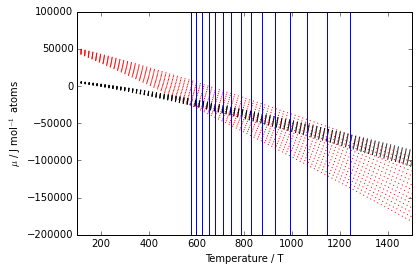

In [31]:
for i, p in enumerate(P_table):
    # plt.plot(T_table, eqm_table[:,i+1])
    plt.plot(T, (scipy.polyval(s2_polyfits[-1],T) + k*T*np.log(p/1.0E5)) * eV2jmol/2, 'r:')
    plt.plot(T, (scipy.polyval(s8_polyfits[-1],T) + k*T*np.log(p/1.0E5)) * eV2jmol/8, 'k:')

T_intersect = mu_poly_intersect(s8_polyfits[-1], 8, s2_polyfits[-1], 2, P_table)
for t in T_intersect:
    plt.axvline(x=t, ymin=0, ymax=1)
plt.xlim([min(T), max(T)]) 
plt.xlabel('Temperature / T'); plt.ylabel('$\mu$ / J mol$^{-1}$ atoms')

This looks very promising. Plotting a large set of solutions, we find a satisfactory cubic parameterisation.

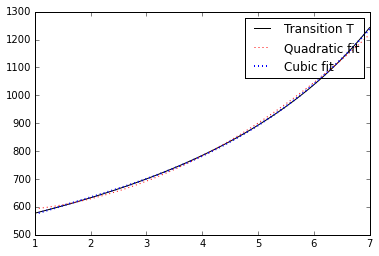

In [32]:
P = 10**(np.linspace(1,7,100))
T_tr = mu_poly_intersect(s8_polyfits[-1],8,s2_polyfits[-1],2,P)
plt.plot(np.log10(P),T_tr, 'k-', label='Transition T')

T_tr_quad = np.polyfit(np.log10(P),T_tr,2)
T_tr_cub = np.polyfit(np.log10(P),T_tr,3)
plt.plot(np.log10(P), np.polyval(T_tr_quad, np.log10(P)), 'r:', label='Quadratic fit')
plt.plot(np.log10(P), np.polyval(T_tr_cub, np.log10(P)), 'b:', linewidth=2, label='Cubic fit')
plt.legend()

Next we need to implement a "switching" function between the two curves. The error function, $\mathrm{erf}$ is a natural choice as it remains smooth under differential operations. We must introduce a couple of parameters in order to position the transition as desired. We also use the complementary error function, $\mathrm{erfc} = \mathrm{erf}$

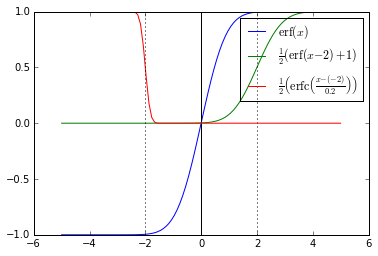

In [33]:
from scipy.special import erf, erfc

x = np.linspace(-5,5,100)
plt.plot(x, erf(x), label=r'$\mathrm{erf}(x)$')
plt.axvline(0,color='k')
plt.plot(x, (erf(x-2)+1)/2, label=r'$\frac{1}{2}\left(\mathrm{erf}(x-2) + 1\right)$')
plt.axvline(2, color='k', linestyle=':')
plt.plot(x, (erfc((x+2.)/0.2))/2., label=r'$\frac{1}{2}\left(\mathrm{erfc}\left(\frac{x - (-2)}{0.2} \right) \right)$')
plt.axvline(-2, color='k', linestyle=':')
plt.legend()

Our model for the mixture therefore becomes:

\begin{equation}
\mu_{S}(T,P) = \frac{1}{2}\left(\mathrm{erfc}\left(\frac{T - T_{tr}}{w} \right) \right) \left[
 \frac{\sum\limits^N_{i=0} x_{{S_8},i} T^i + k T \ln
\frac{P}{P_{\mathrm{ref}}}}{8}\right] +
\frac{1}{2}\left(\mathrm{erf}\left(\frac{T - T_{tr}}{w} \right) +1 \right)
    \frac{\sum\limits^N_{i=0} x_{{S_2},i} T^i + k T \ln \frac{P}{P_{\mathrm{ref}}}}{2}
\end{equation}
where $T_{tr} = f(P)$ is the transition temperature, and $w$ is a parameter controlling the width of the transition region.

In [34]:
def mu_model1(s8_poly, s2_poly, T, P, a=10, units='eV'):
    """Return mu in eV from single-parameter model of S2/S8 transition.
    If T and/or P are iterable, return array with P in columns and T in rows"""

    T_tr = mu_poly_intersect(s8_poly, 8, s2_poly, 2, P)
    T = np.array(T)
    T = T.reshape(-1,1) # Convert to column vector
    
    if hasattr(T, '__iter__'):
        T = np.array(T)
        T = T.reshape(-1,1) # Convert to column vector

    if hasattr(P, '__iter__'):
        P = np.array(P)
        P = P.flatten() # Convert to a row vector
    mu = (
        0.5 * (erfc((T - T_tr)/a)) * (1./8.) * (np.polyval(s8_poly,T) + k*T*np.log(P/1E5)) +
        0.5 * (erf((T - T_tr)/a)+1) *  (1./2.) * (np.polyval(s2_poly,T) + k*T*np.log(P/1E5))
        # 0.5 * (1./8.) * (np.polyval(s8_poly,T) + k*T*np.log(P/1E5)) +
        # 0.5 * (1./2.) * (np.polyval(s2_poly,T) + k*T*np.log(P/1E5))
    )
    if units in ('eV', 'eV atom-1', 'eV/atom'):
        return mu
    elif units in ('jmol','Jmol','jmol-1','Jmol-1','j/mol','J/mol'):
        return mu * eV2jmol
    elif units in ('kJmol','kjmol','kJmol-1','kjmol-1','kJ/mol','kj/mol'):
        return mu * (eV2jmol * 1E-3)
    else:
        raise Exception('Units \"{0}\" not known. Try \"eV\", \"Jmol-1\" or \"kJmol-1\"'.format(units))

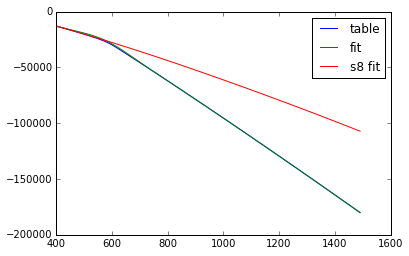

In [35]:
mu_fit1 = mu_model1(s8_polyfits[-1], s2_polyfits[-1], T_table, P_table, a=100, units='Jmol')
err = mu_fit1 - eqm_table[:,1:]
plt.plot(T_table, eqm_table[:,1], label='table')
plt.plot(T_table, mu_fit1[:,0], label='fit')
plt.plot(T_table, (np.polyval(s8_polyfits[-1],T_table) + k*T_table*np.log(P_table[0]/1E5)) * eV2jmol * 1./8., label='s8 fit')
plt.legend()

This is very effective! The next step is to look at a high-pressure system where the transition region is broader.

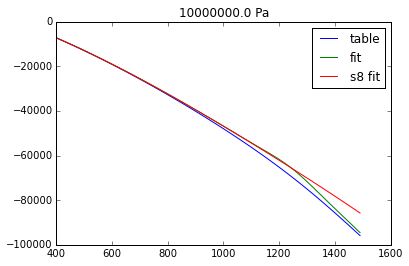

In [36]:
plt.plot(T_table, eqm_table[:,-1], label='table')
plt.plot(T_table, mu_fit1[:,-1], label='fit')
plt.plot(T_table, (np.polyval(s8_polyfits[-1],T_table) + k*T_table*np.log(P_table[-1]/1E5)) * eV2jmol * 1./8., label='s8 fit')
plt.title('{0} Pa'.format(P_table[-1]))
plt.legend()


The parameter $a$ smoothes the transition, but does not account for the slight depression in energy at the transition. In fact, mixing in the higher S$_2$ energy slightly before the transition results in the energy being overestimated before the transition.

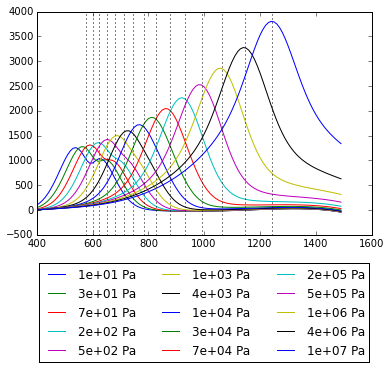

In [37]:
for i_p, p in enumerate(P_table):
    plt.plot(T_table, err[:,i_p], label='{0:3.0e} Pa'.format(p))
for t in T_intersect:
    plt.axvline(x=t, ymin=0, ymax=1, color='k', linestyle=':')
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5,-0.1))

This error looks as though it would be well approximated by a gaussian function
\begin{equation}
\epsilon = a e^{-\frac{(T-b)^2}{2c^2}}
\end{equation}
where the position $b$ is close to the estimated transition temperature, the width $c$ is roughly constant and the height $a$ increases with pressure.

| Pressure / Pa | a (height) | b (position) | c (width) | b-T(trans) |
|---------------|------------|--------------|-----------|------------|
|    1.00e+01   |   1214.3   |      569.5   |    88.98  |    -8.00   |
|    2.68e+01   |   1242.8   |      590.7   |    86.41  |    -9.29   |
|    7.20e+01   |   1280.2   |      613.4   |    84.26  |   -10.90   |
|    1.93e+02   |   1329.1   |      638.2   |    82.39  |   -12.51   |
|    5.18e+02   |   1392.0   |      665.6   |    80.82  |   -13.95   |
|    1.39e+03   |   1471.1   |      696.1   |    79.72  |   -15.08   |
|    3.73e+03   |   1567.7   |      730.2   |    79.38  |   -15.85   |
|    1.00e+04   |   1683.1   |      768.3   |    80.12  |   -16.20   |
|    2.68e+04   |   1818.7   |      811.3   |    82.35  |   -16.14   |
|    7.20e+04   |   1975.9   |      859.9   |    86.65  |   -15.60   |
|    1.93e+05   |   2155.7   |      915.4   |    93.94  |   -14.45   |
|    5.18e+05   |   2357.7   |      979.3   |   105.84  |   -12.27   |
|    1

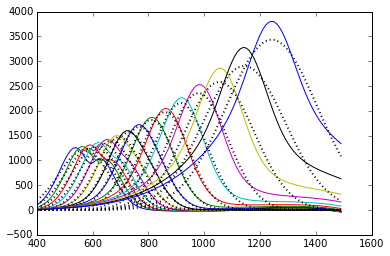

In [38]:
from scipy.optimize import curve_fit
def gaussian(x, a, b, c):
    return a * np.exp(-((x-b)**2)/(2*c**2))


print "| Pressure / Pa | a (height) | b (position) | c (width) | b-T(trans) |"
print "|---------------|------------|--------------|-----------|------------|"
for i_p, p in enumerate(P_table):
    popt, pcov = curve_fit(gaussian, T_table, err[:,i_p], p0=(2000,T_intersect[i_p], 200))
    a, b, c = popt
    plt.plot(T_table, err[:,i_p])
    plt.plot(T_table, gaussian(T_table, *popt), linestyle=':', color='k', linewidth=2)
    print "|    {0:3.2e}   | {1:8.1f}   |   {2:8.1f}   | {3:8.2f}  | {4:8.2f}   |".format(p, a, b, c, b-T_intersect[i_p])

The width appears to be fairly consistent, and the location on the T-axis closely tracks the estimated transition T. The relationship between peak height and log(P) appears to be smooth and nonlinear; a quadratic fit suffices.

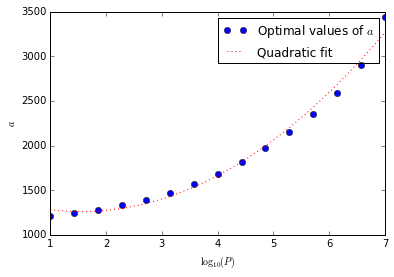

In [39]:
a = [curve_fit(gaussian, T_table, err[:,i_p], p0=(2000,T_intersect[i_p], 200))[0][0] for i_p, p in enumerate(P_table)]
plt.plot(np.log10(P_table), a,'bo', label=r'Optimal values of $a$')
plt.xlabel(r'$\log_{10}(P)$')
plt.ylabel(r'$a$')

quad_fit_a = np.polyfit(np.log10(P_table), a, 2)
plt.plot(np.log10(P_table), np.polyval(quad_fit_a, np.log10(P_table)),'r:', label='Quadratic fit')
plt.legend()

It seems therefore that we can form a reasonable parameterisation with the following model:

\begin{equation}
\mu_{S}(T,P) = \frac{1}{2}\left(\mathrm{erfc}\left(\frac{T - T_{tr}}{w} \right) \right) \left[
 \frac{\sum\limits^N_{i=0} x_{{S_8},i} T^i + k T \ln
\frac{P}{P_{\mathrm{ref}}}}{8}\right] +
\frac{1}{2}\left(\mathrm{erf}\left(\frac{T - T_{tr}}{w} \right) +1 \right)
    \frac{\sum\limits^N_{i=0} x_{{S_2},i} T^i + k T \ln \frac{P}{P_{\mathrm{ref}}}}{2}
    - (a_0 + a_1 \log_{10}(P) + a_2 (\log_{10}(P))^2 ) \exp\left({-\frac{(T-(T_{tr}-b)))^2}{2c^2}}\right)
\end{equation}
where $T_{tr}$ is represented by a polynomial in $\log_{10}(P)$.

In [40]:
### NOMINAL VALUES FOR CORRELATION TERMS BASED ON THIS NOTEBOOK ###

s8_poly_string =  "S8 free energy polynomial:  " + ("\n"+" "*28).join(["x_S8_{0}: {{{0}:10.3e}}".format(i) for i in range(len(s8_polyfits[-1]))])
print s8_poly_string.format(*reversed(s8_polyfits[-1]))
s2_poly_string =  "S2 free energy polynomial:  " + ("\n"+" "*28).join(["x_S2_{0}: {{{0}:10.3e}}".format(i) for i in range(len(s2_polyfits[-1]))])
print s2_poly_string.format(*reversed(s2_polyfits[-1]))
T_tr_poly_string = "T_tr polynomial:" +" "*15 + ("\n"+" "*31).join(["a_{0}: {{{0}:10.3e}}".format(i) for i in range(len(T_tr_cub))])
print T_tr_poly_string.format(*reversed(T_tr_cub))
a_poly_string = "Gaussian height a polynomial:  " + ("\n"+" "*31).join(["a_{0}: {{{0}:10.3e}}".format(i) for i in range(len(quad_fit_a))])
print a_poly_string.format(*reversed(quad_fit_a))
print "Estimated gaussian parameters:   b:   10"
print " "*33 + "c:   80"
print "Arbitrarily assigned erf width:  w:   100"

S8 free energy polynomial:  x_S8_0:  7.620e-01
                            x_S8_1: -2.457e-03
                            x_S8_2: -4.012e-06
                            x_S8_3:  1.808e-09
                            x_S8_4: -3.810e-13
S2 free energy polynomial:  x_S2_0:  1.207e+00
                            x_S2_1: -1.848e-03
                            x_S2_2: -8.566e-07
                            x_S2_3:  4.001e-10
                            x_S2_4: -8.654e-14
T_tr polynomial:               a_0:  5.077e+02
                               a_1:  7.272e+01
                               a_2: -8.295e+00
                               a_3:  1.828e+00
Gaussian height a polynomial:  a_0:  1.424e+03
                               a_1: -2.123e+02
                               a_2:  6.789e+01
Estimated gaussian parameters:   b:   10
                                 c:   80
Arbitrarily assigned erf width:  w:   100
